In [197]:
# 导库
import numpy as np  # 数值计算
import pandas as pd  # 数据处理
import scanpy as sc  # Scanpy单细胞RNA测序数据分析工具包

# 设置日志的详细程度，0表示只显示错误，1显示警告，2显示信息，3显示提示
sc.settings.verbosity = 3

# 打印Scanpy包的头信息，包括版本号等信息
sc.logging.print_header()

# 设置绘图参数，设置图片的分辨率(dpi)为80，并将背景颜色设置为白色
sc.settings.set_figure_params(dpi=80, facecolor='white')

# 指定用于存储分析结果文件的路径
results_file = 'output/pbmc3k.h5ad'

# 从指定的目录读取10x Genomics格式的数据文件
# 参数./filtered_gene_bc_matrices/hg19/是存放MTX文件的目录
# 参数var_names='gene_symbols'表示使用基因符号作为变量名
# 参数cache=True表示缓存文件，以便以后更快地读取
adata = sc.read_10x_mtx(
    './data/',
    var_names='gene_symbols',
    cache=True,
)

... reading from cache file cache\data-matrix.h5ad


normalizing counts per cell
    finished (0:00:00)


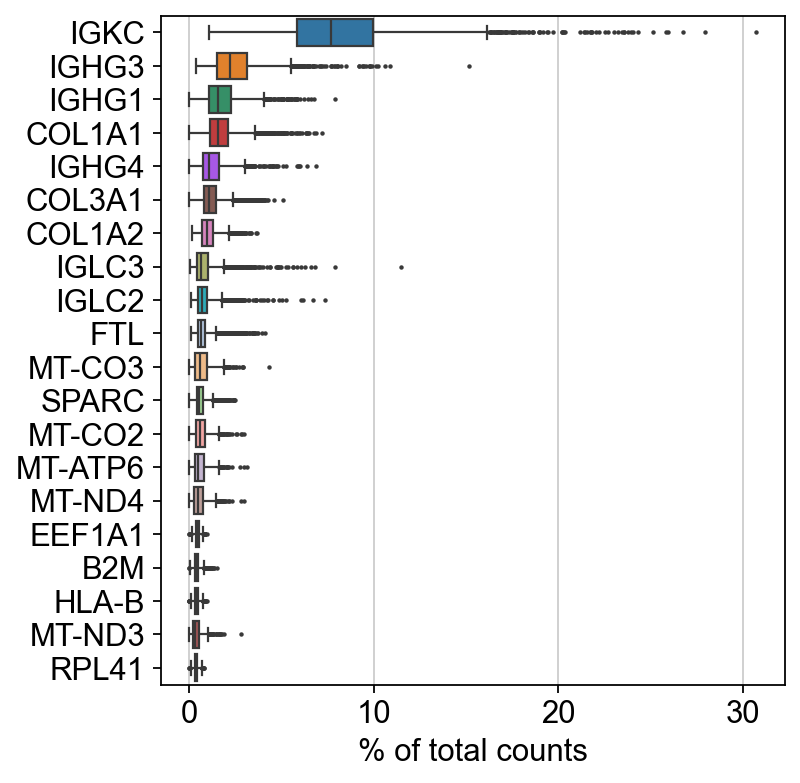

In [198]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [199]:
# # 过滤低质量细胞样本
sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

filtered out 2 cells that have less than 200 genes expressed


In [200]:
# 将线粒体基因标记为 'mt'
# 创建一个新的列 'mt'，用于标记线粒体基因。
# 如果基因名以 "MT-" 开头，则认为它是线粒体基因，标记为 True；否则标记为 False。
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# 计算质量控制（QC）指标
sc.pp.calculate_qc_metrics(
    adata,                          # 输入的 AnnData 对象
    qc_vars=["mt"],                 # 指定需要计算的 QC 指标变量，这里计算线粒体基因（mt）相关的指标
    percent_top=None,               # 不计算最高表达基因的百分比（默认值）
    log1p=False,                    # 不对结果取 log1p 变换（默认值）
    inplace=True                    # 将计算结果直接存储在 adata 对象中
)

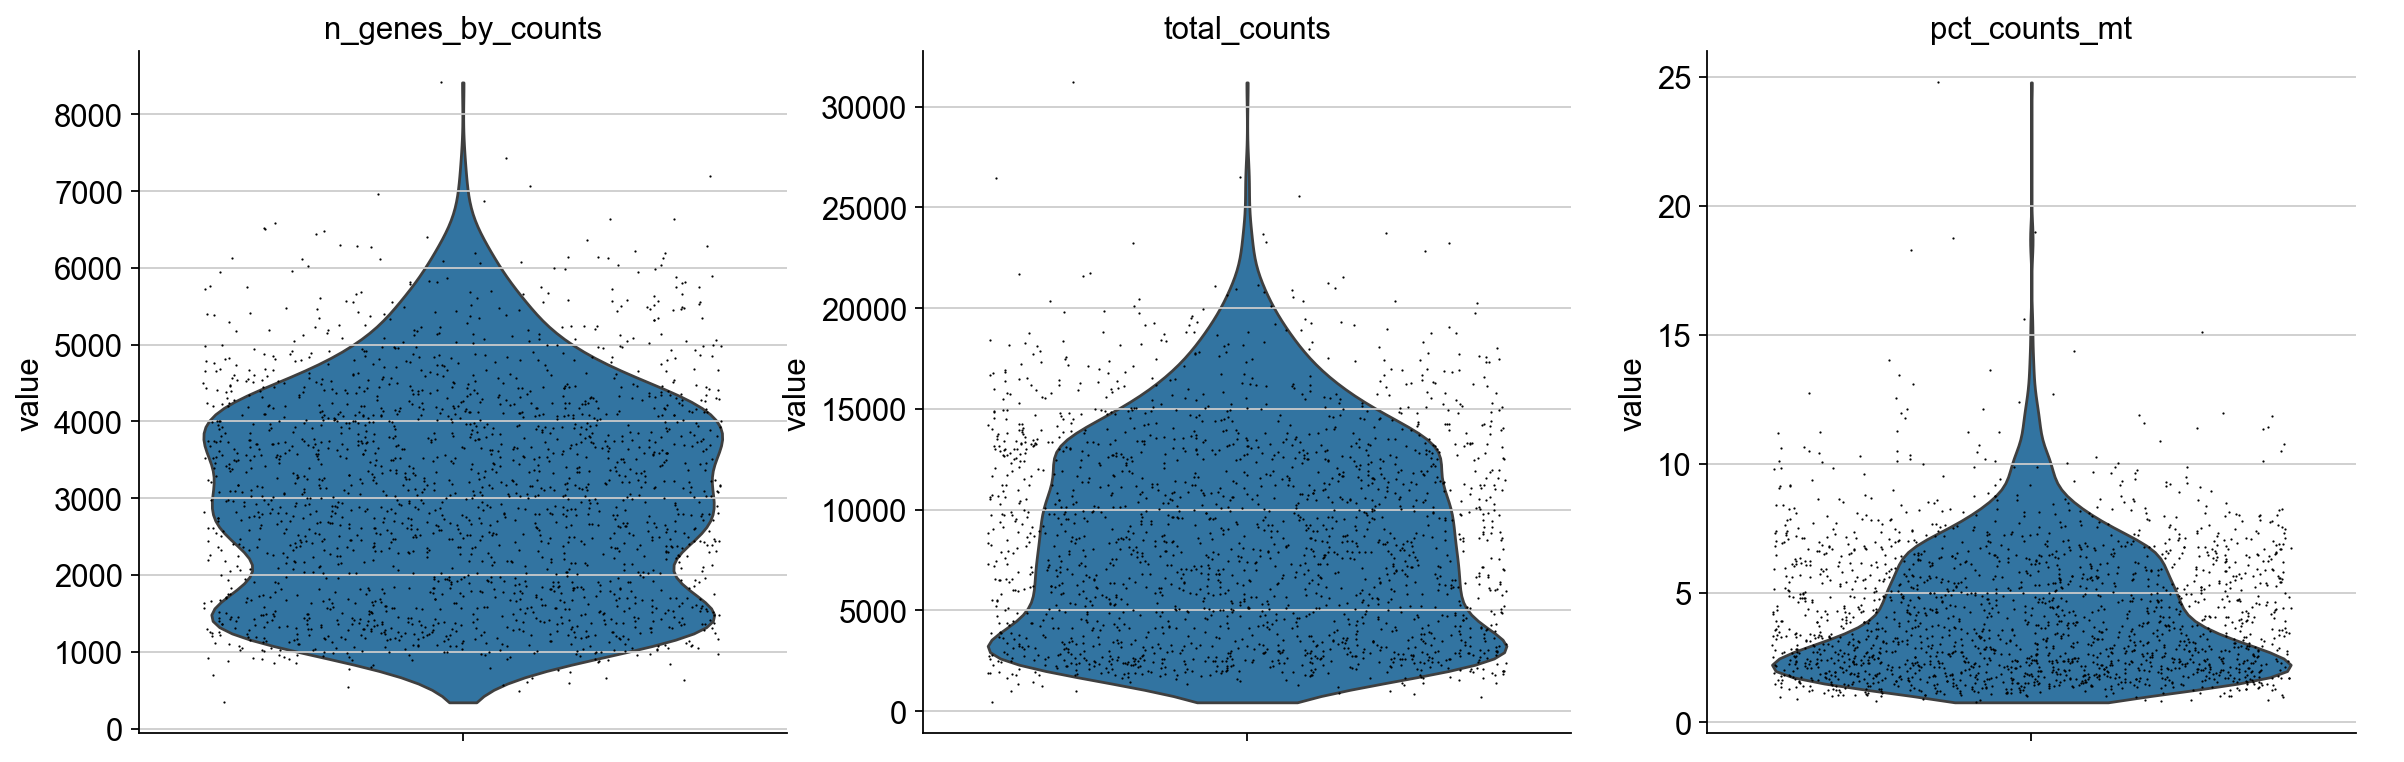

In [201]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

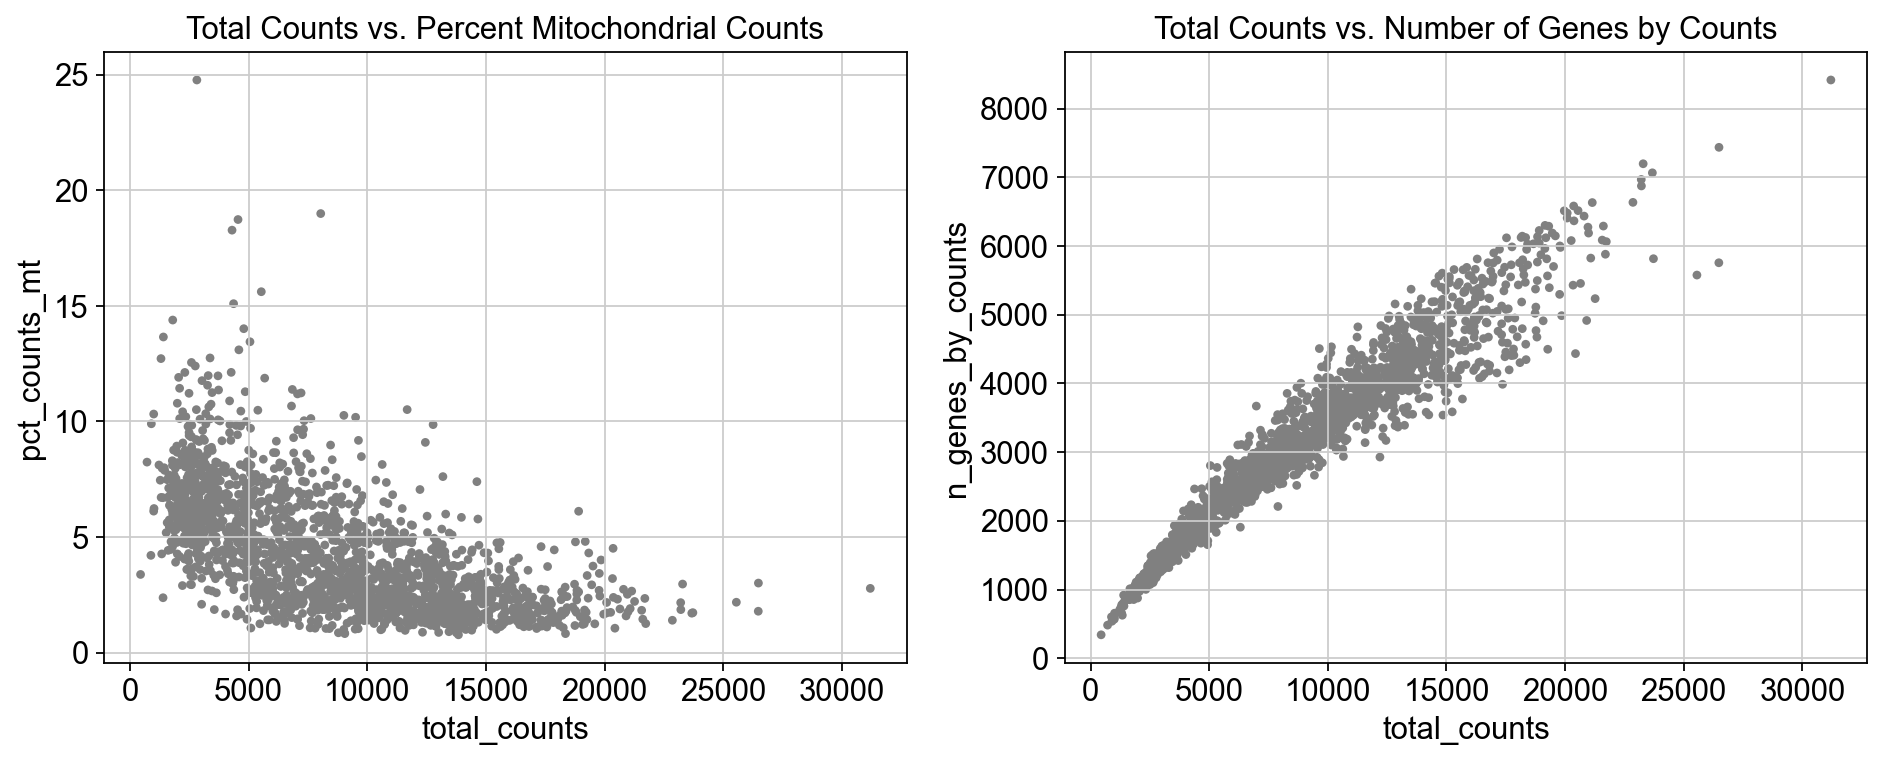

In [202]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
# 在第一个子图中绘制总表达量与线粒体基因比例的关系
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", ax=axes[0], show=False)  
axes[0].set_title("Total Counts vs. Percent Mitochondrial Counts")  
# 在第二个子图中绘制总表达量与检测到的基因数的关系
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", ax=axes[1], show=False)  
axes[1].set_title("Total Counts vs. Number of Genes by Counts") 
plt.tight_layout()
plt.show()

In [203]:
# 筛选检测到的基因数小于2500的细胞
# adata.obs.n_genes_by_counts 是一个包含每个细胞检测到的基因数的列
# 这里我们保留基因数小于2500的细胞，排除基因数过多的异常细胞
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

# 筛选线粒体基因比例小于5%的细胞
# adata.obs.pct_counts_mt 是一个包含每个细胞线粒体基因表达比例的列
# 这里我们保留线粒体基因比例小于5%的细胞，排除可能受损的细胞
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [204]:
# 对数据进行总和归一化，使每个细胞的总表达量（UMI数）标准化为目标值
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [205]:
# 做对数
sc.pp.log1p(adata)

In [206]:
# 寻找高变基因，指在不同细胞中表达水平差异较大的基因，这些基因通常在后续分析中更具生物学意义
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


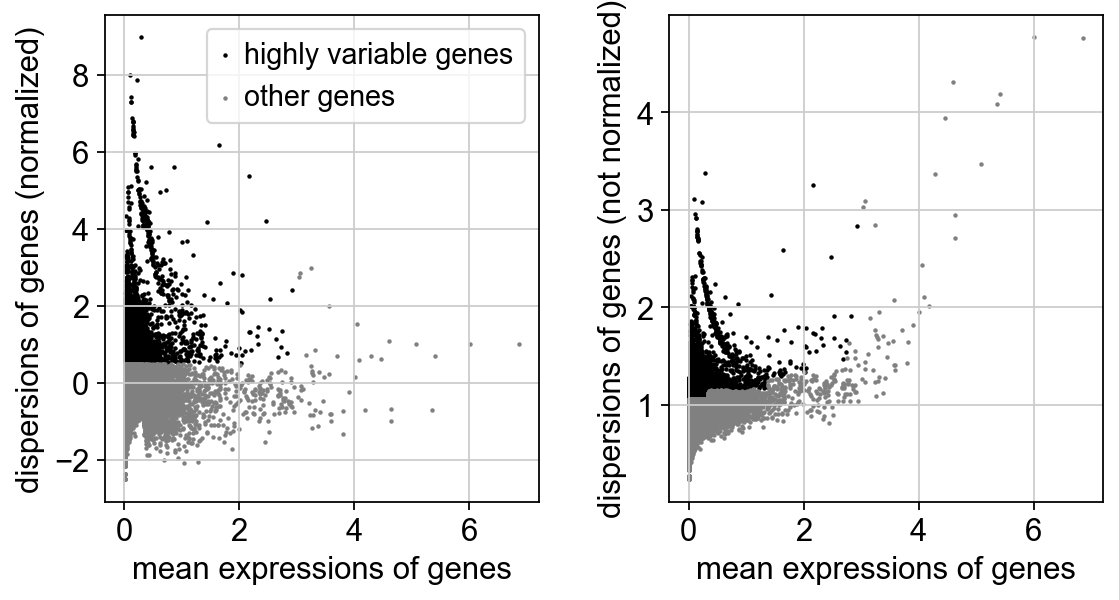

In [207]:
sc.pl.highly_variable_genes(adata)

# 将 AnnData 对象的属性设置为标准化和对数化的原始基因表达，以便以后用于基因表达的差异检测和可视化。这只是冻结 AnnData 对象的状态。

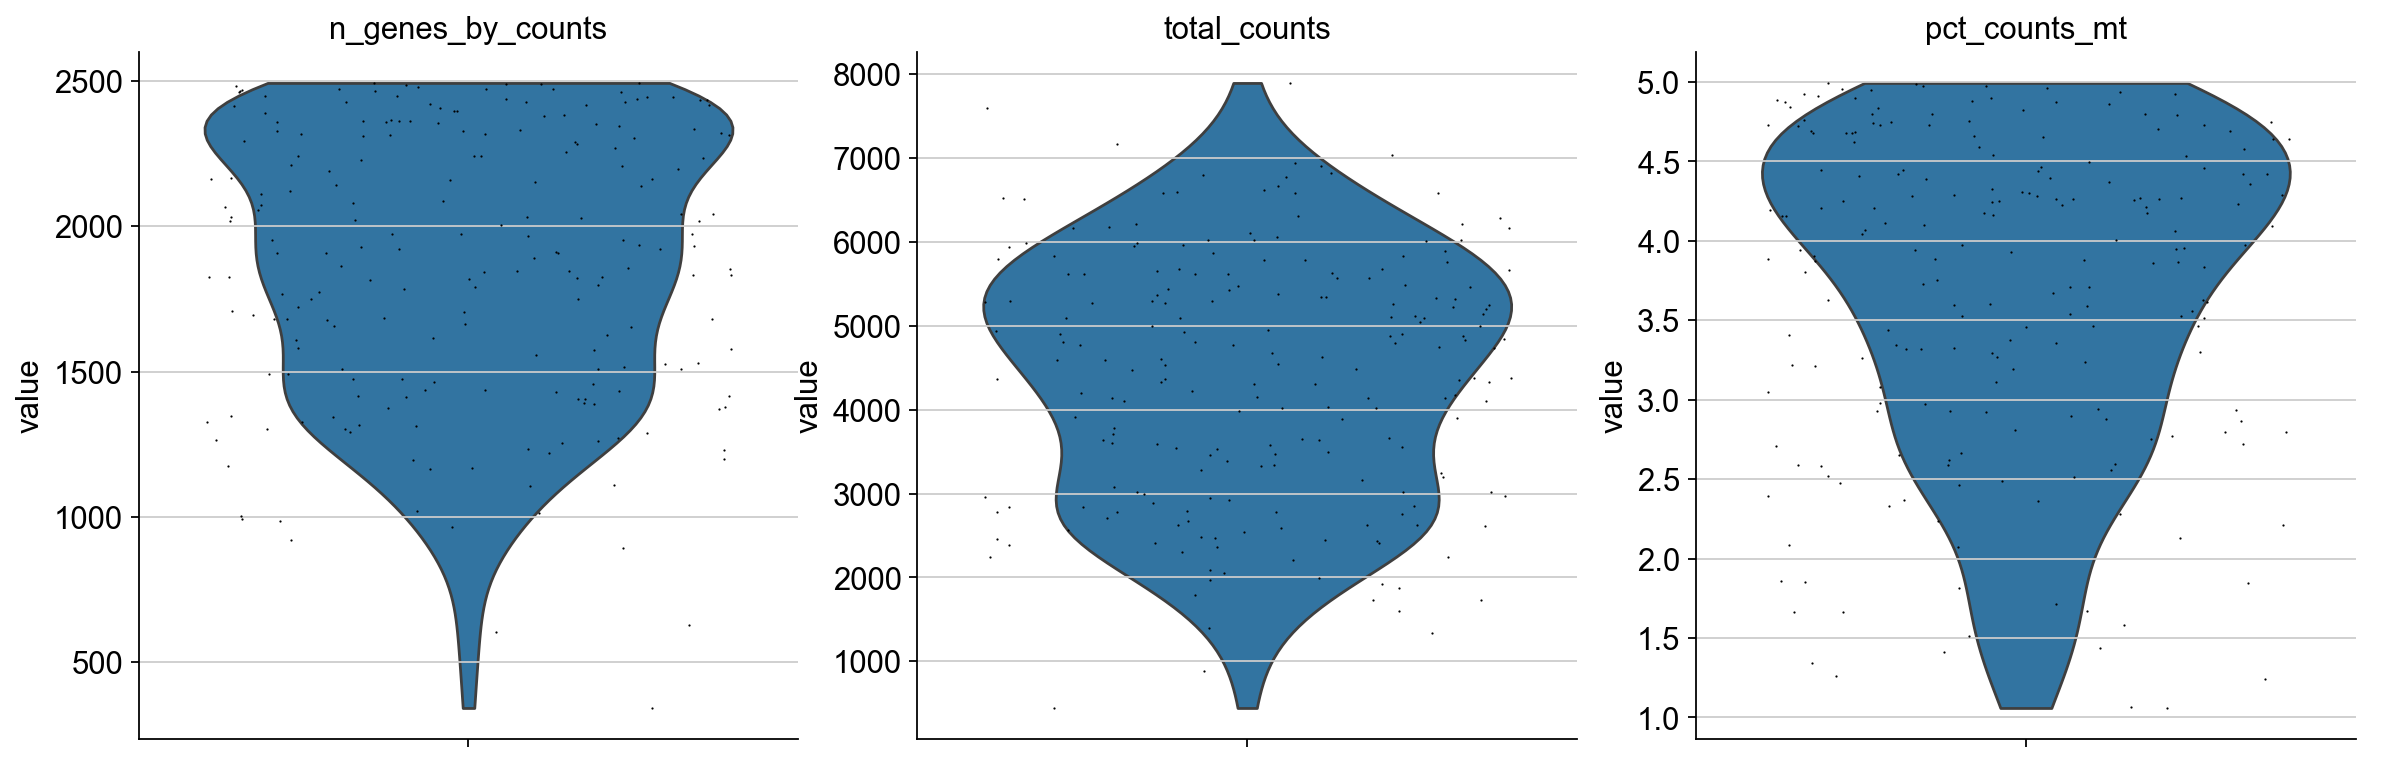

In [208]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# PCA

In [209]:
# 对数据进行PCA降维
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


In [210]:
print(adata.var_names)

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)


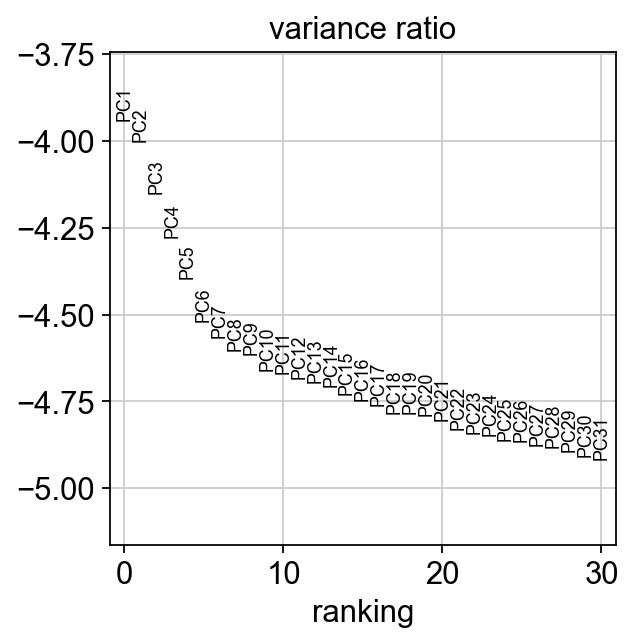

In [211]:
sc.pl.pca_variance_ratio(adata, log=True)

In [212]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 210 × 33538
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [213]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [222]:
sc.tl.leiden(adata, resolution=0.5)  

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [223]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


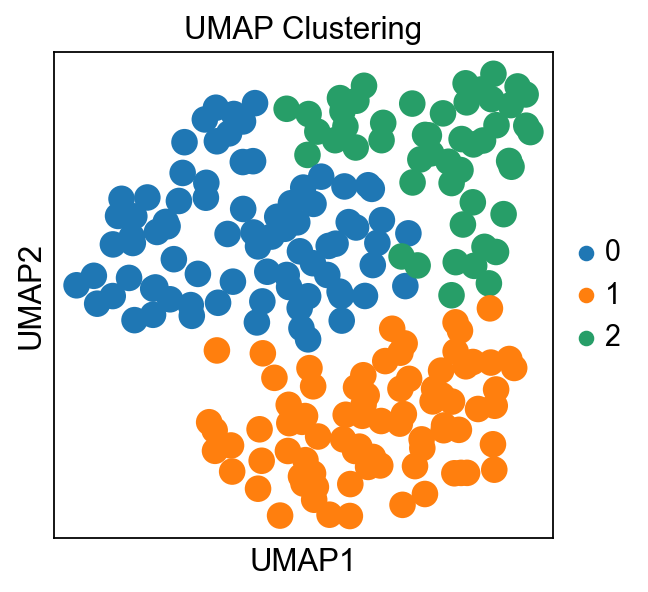

In [224]:
# 绘制 UMAP 图，按聚类结果着色
sc.pl.umap(adata, color="leiden", title="UMAP Clustering")

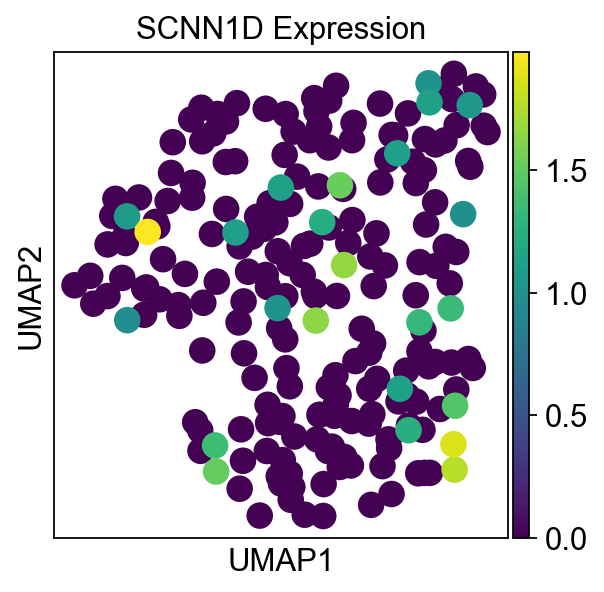

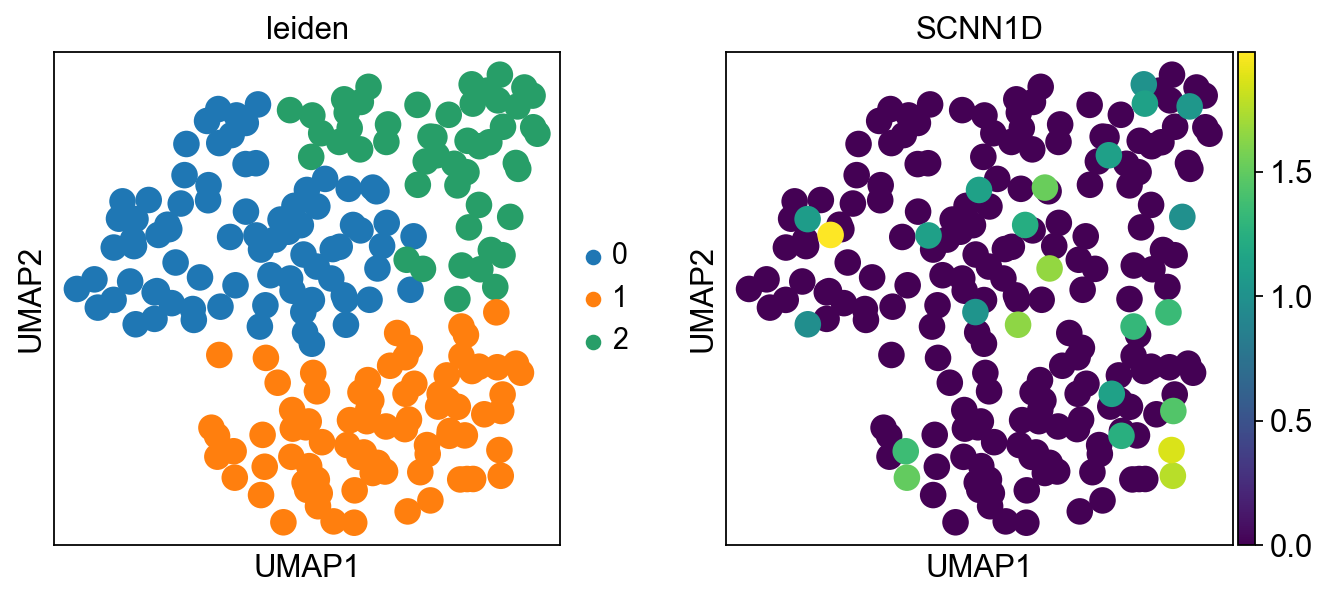

In [225]:
# 绘制 SCNN1D 基因的表达
sc.pl.umap(adata, color="SCNN1D", title="SCNN1D Expression")

# 同时绘制 SCNN1D 和聚类结果
sc.pl.umap(adata, color=["leiden", "SCNN1D"], ncols=2)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


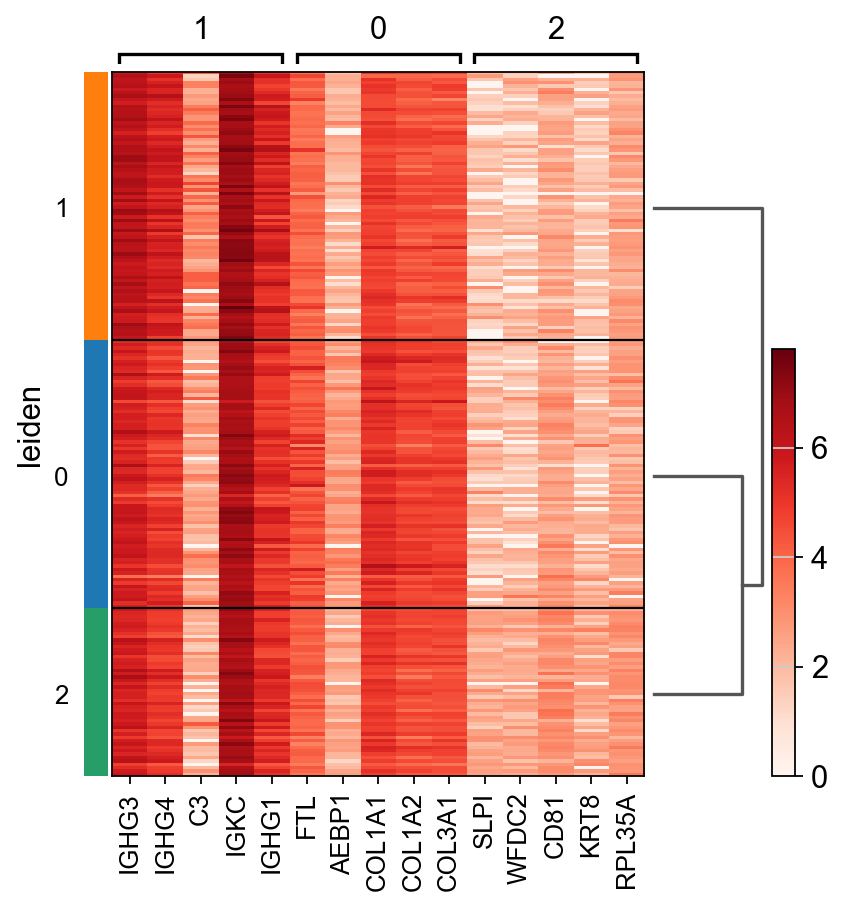

,0,1,2
0,FTL,IGHG3,SLPI
1,AEBP1,IGHG4,WFDC2
2,COL1A1,C3,CD81
3,COL1A2,IGKC,KRT8
4,COL3A1,IGHG1,RPL35A
5,CTSK,RPS4X,KRT19
6,HTRA1,FAM30A,MT-ND1
7,SPARC,EFEMP1,MSLN
8,FN1,FCN1,TMEM205
9,LUM,RPL13,NDUFA13


In [226]:
# 进行差异表达分析
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# 可视化差异表达基因热图，将颜色更改为红色
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    show_gene_labels=True,
    cmap='Reds'  # 使用红色调
)

# 查看具体基因列表
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

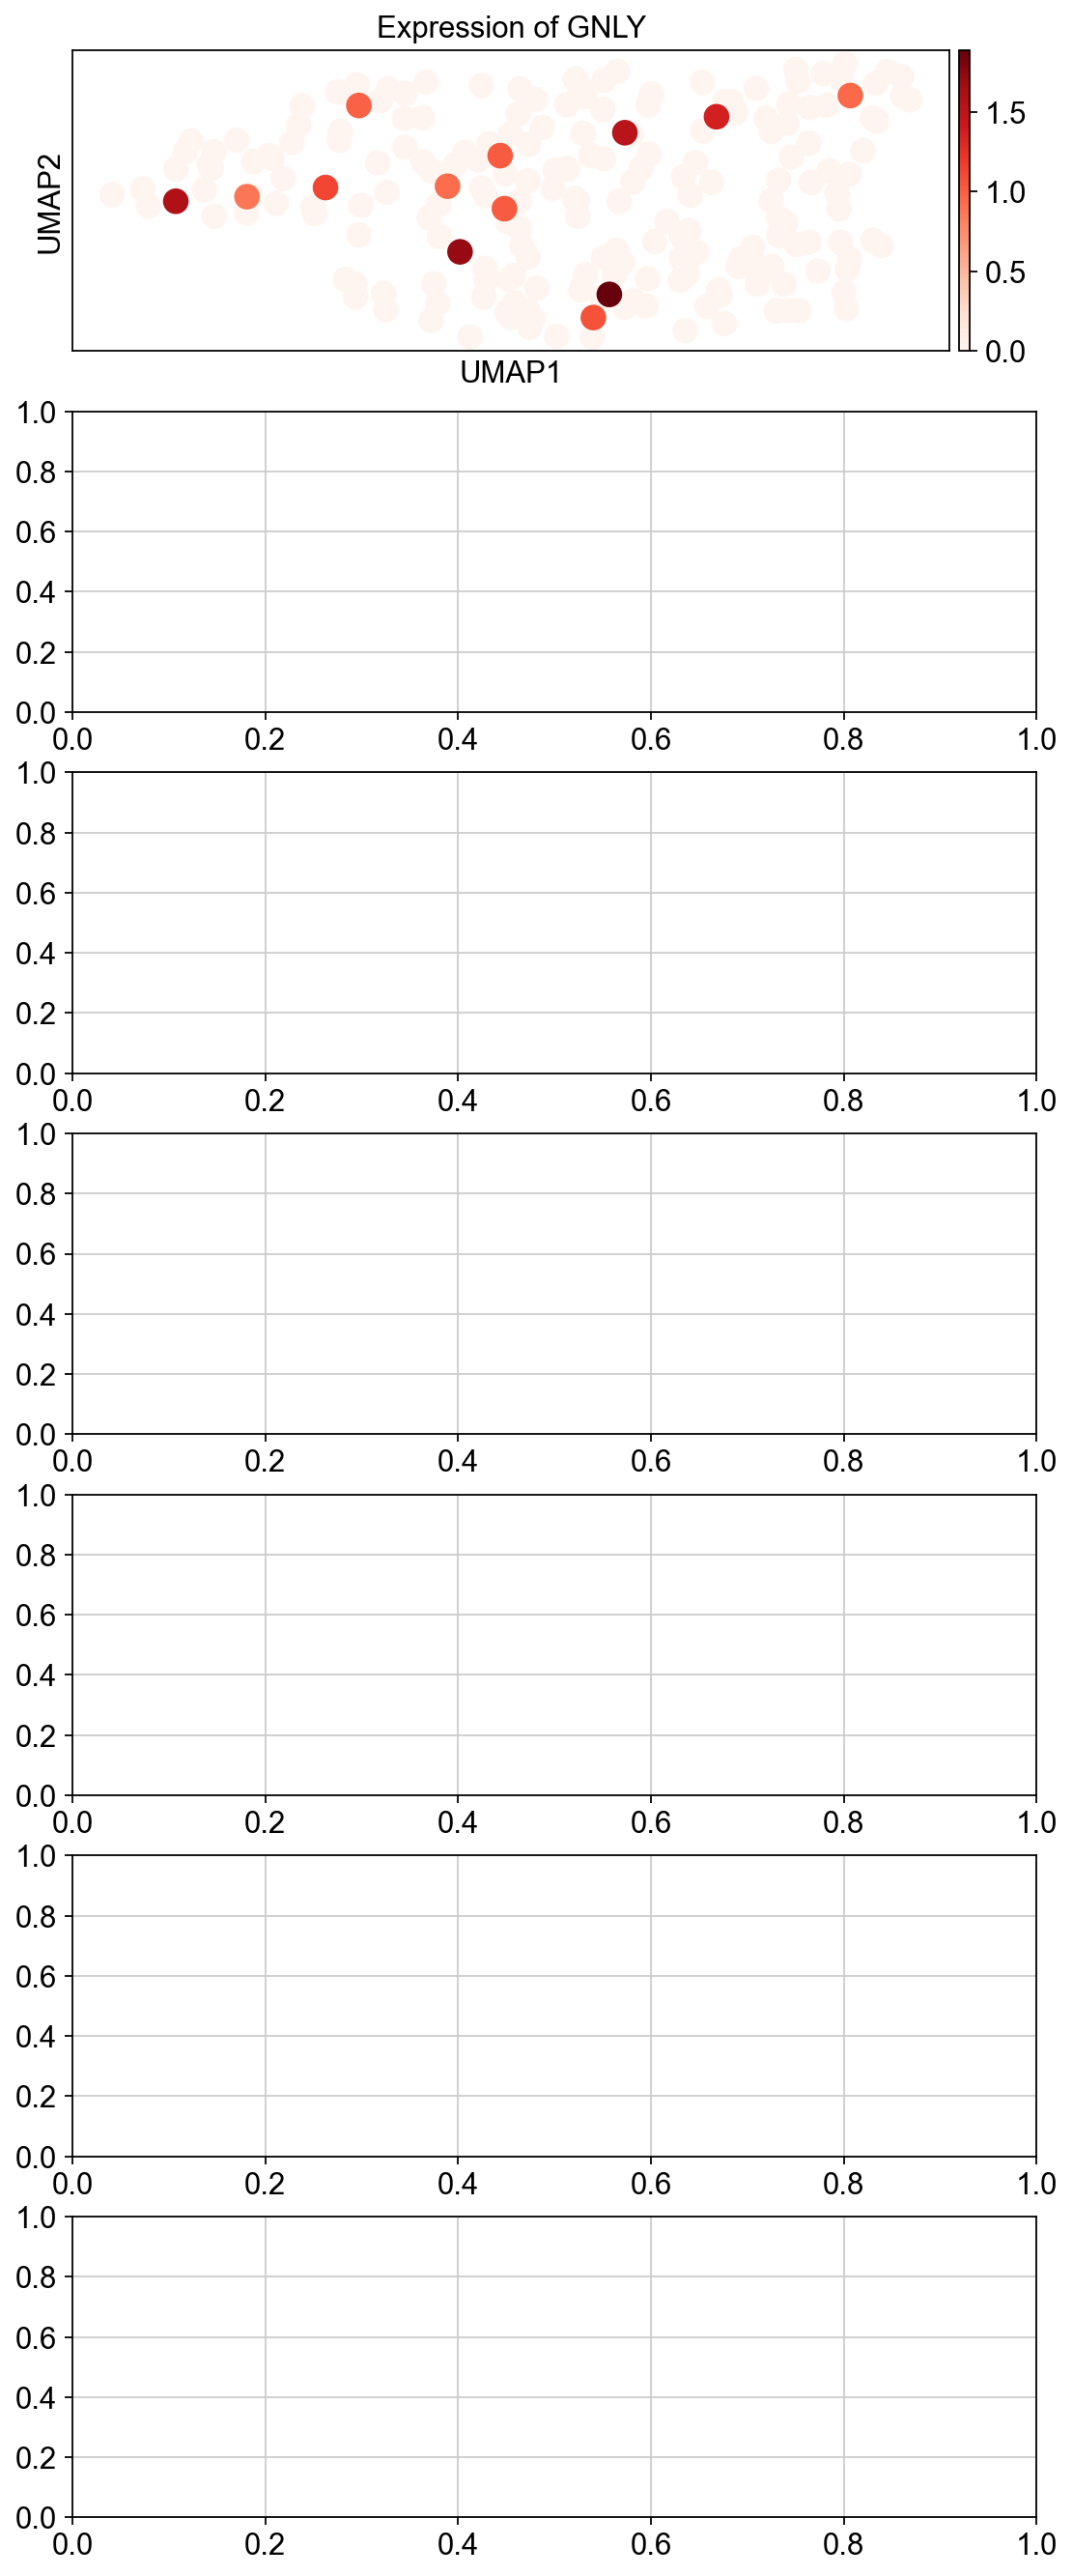

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

Present genes: ['GNLY', 'NKG7', 'KLRD1', 'KLRF1', 'FCGR3A', 'PRF1', 'GZMB']


In [231]:
import matplotlib.pyplot as plt

# 检查NK细胞标记基因的表达
nk_markers = ["GNLY", "NKG7", "KLRD1", "KLRF1", "FCGR3A", "PRF1", "GZMB"]

# 筛选出表达NK标记基因的细胞并绘制UMAP图
present_genes = []
absent_genes = []

# 创建一个图形和多个子图
fig, axes = plt.subplots(nrows=len(nk_markers), ncols=1, figsize=(8, 3 * len(nk_markers)))

for i, gene in enumerate(nk_markers):
    if gene in adata.var_names:
        present_genes.append(gene)
        # 绘制UMAP图
        sc.pl.umap(adata, color=gene, title=f"Expression of {gene}", cmap='Reds', ax=axes[i])
    else:
        absent_genes.append(gene)

# 调整子图间距
plt.tight_layout()

# 显示图形
plt.show()

# 打印结果
print(f"Present genes: {present_genes}")
if absent_genes:
    print(f"Absent genes: {absent_genes}")

Gene GNLY is present.


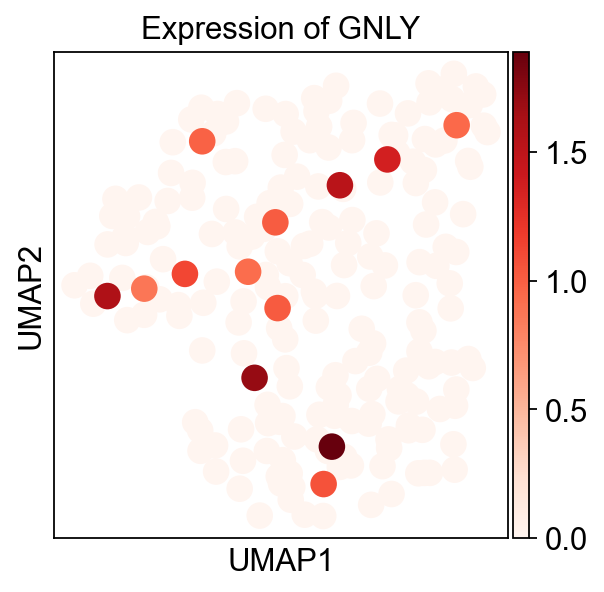

Gene NKG7 is present.


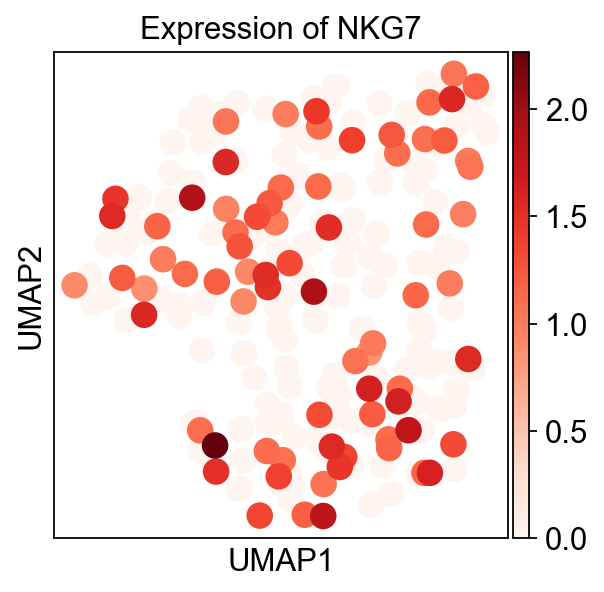

Gene KLRD1 is present.


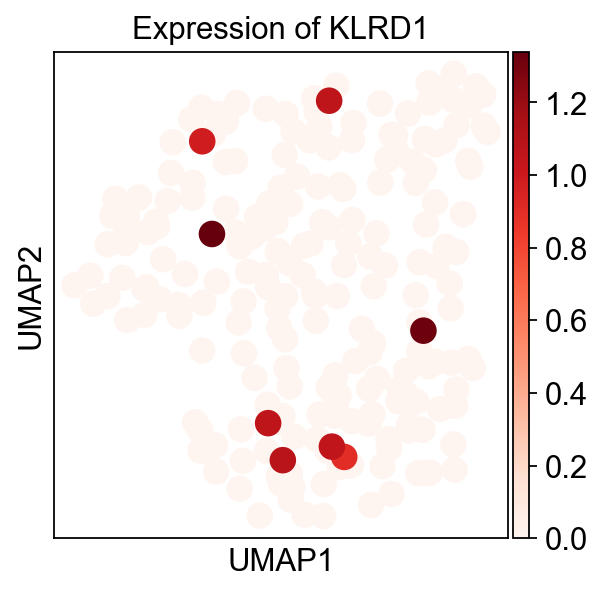

Gene KLRF1 is present.


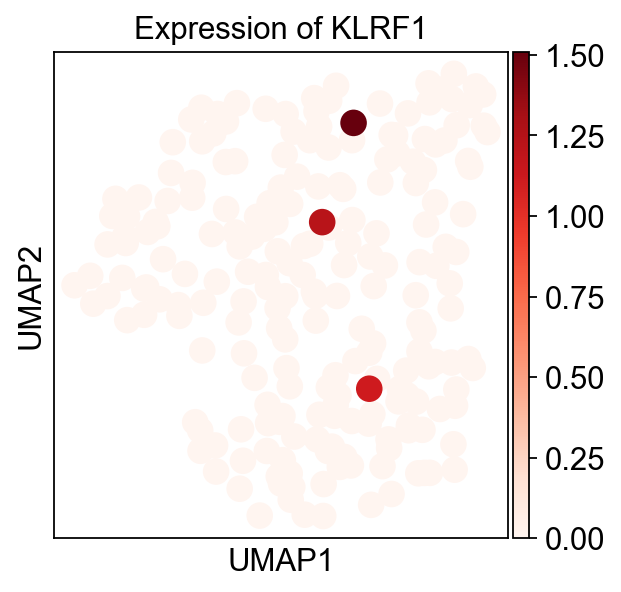

Gene FCGR3A is present.


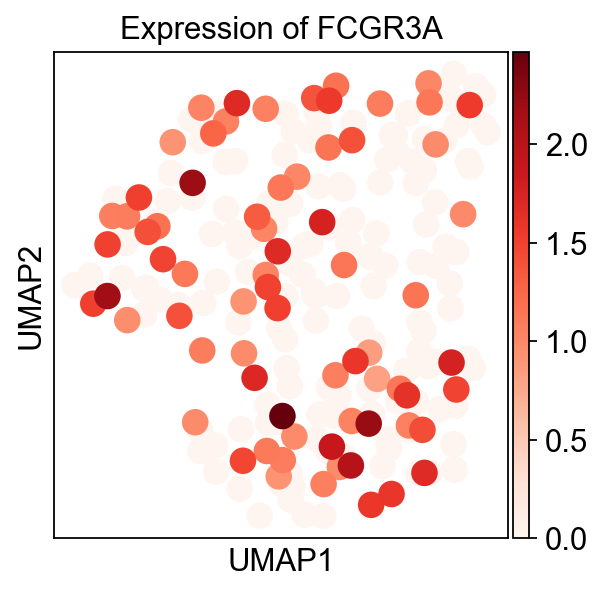

Gene PRF1 is present.


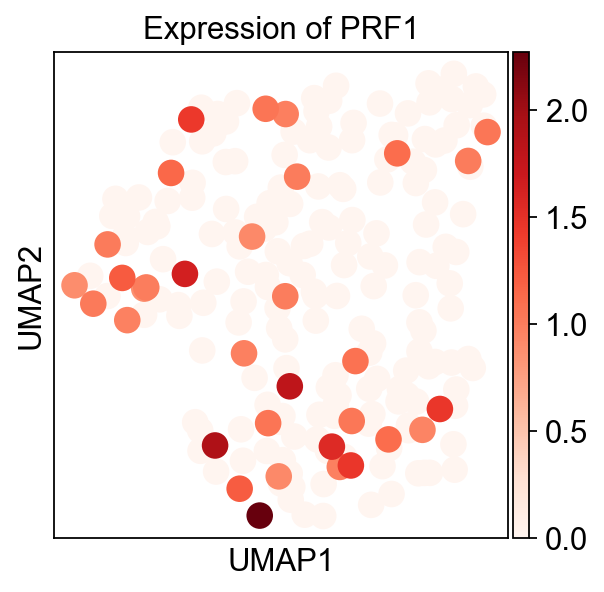

Gene GZMB is present.


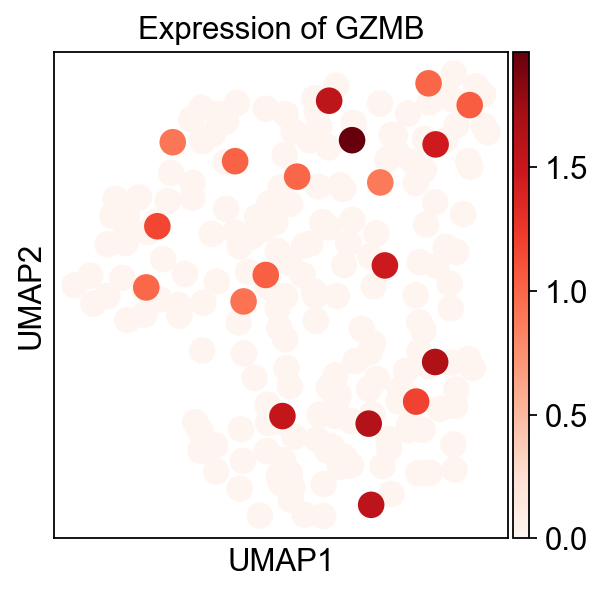

In [233]:
# 检查NK细胞标记基因的表达
nk_markers = ["GNLY", "NKG7", "KLRD1", "KLRF1", "FCGR3A", "PRF1", "GZMB"]

# 筛选出表达NK标记基因的细胞
for gene in nk_markers:
    if gene in adata.var_names:
        print(f"Gene {gene} is present.")
        sc.pl.umap(adata, color=gene, title=f"Expression of {gene}", cmap='Reds')
    else:
        print(f"Gene {gene} is not present in the data.")


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


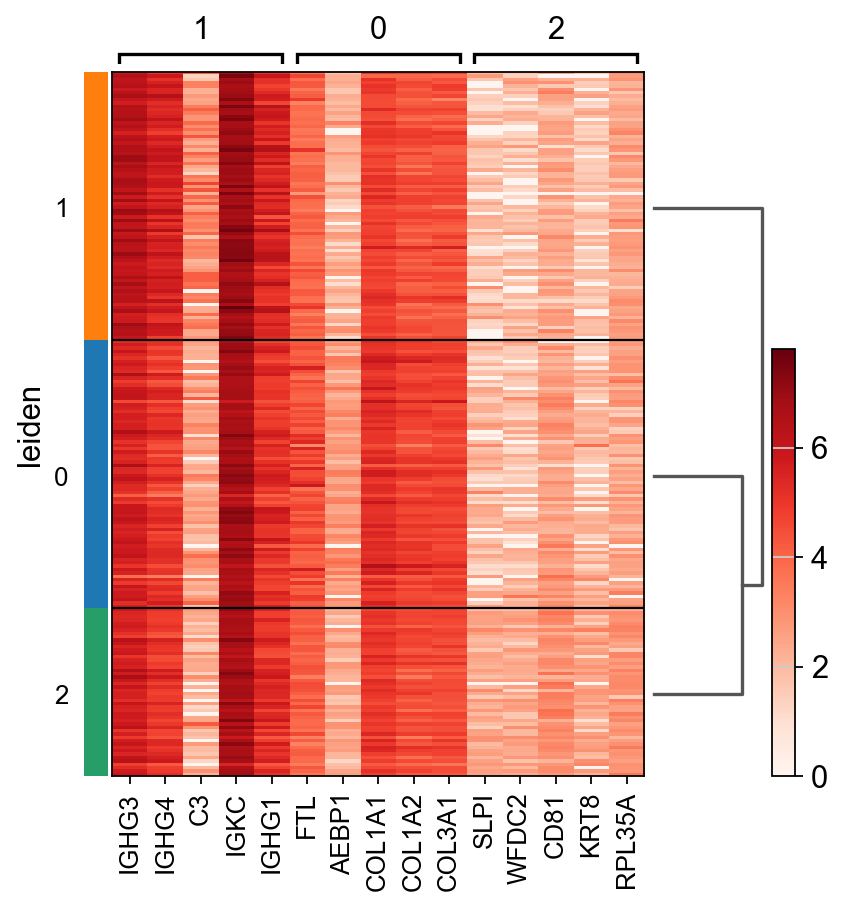

        0       1        2
0     FTL   IGHG3     SLPI
1   AEBP1   IGHG4    WFDC2
2  COL1A1      C3     CD81
3  COL1A2    IGKC     KRT8
4  COL3A1   IGHG1   RPL35A
5    CTSK   RPS4X    KRT19
6   HTRA1  FAM30A   MT-ND1
7   SPARC  EFEMP1     MSLN
8     FN1    FCN1  TMEM205
9     LUM   RPL13  NDUFA13


In [234]:
# 进行差异表达分析
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# 可视化差异表达基因热图
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    show_gene_labels=True,
    cmap='Reds'
)

# 查看差异表达基因列表
diff_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
print(diff_genes.head(10))